In [ ]:

!pip install laspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for laspy: filename=laspy-2.2.0-py3-none-any.whl size=63856 sha256=f1f72e8ab90ff40331495ac87291cb1f10b5af4220426b69c33991b81b2150c4
  Stored in directory: /root/.cache/pip/wheels/19/6e/01/0dfe379f345dfcfd77907d182cc2b6bae804b52eba66c028f6
Successfully built laspy


In [ ]:
import numpy as numpyPackage
import laspy as laspyPackage
import matplotlib.pyplot as plotXYPackage
from scipy.interpolate import griddata
from scipy import ndimage, misc
import csv

# unique only to this website, google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Xsize:  (4016, 4016)
Ysize:  (4016, 4016)
Zsize:  (4016, 4016)


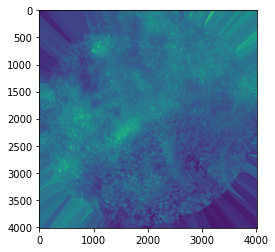

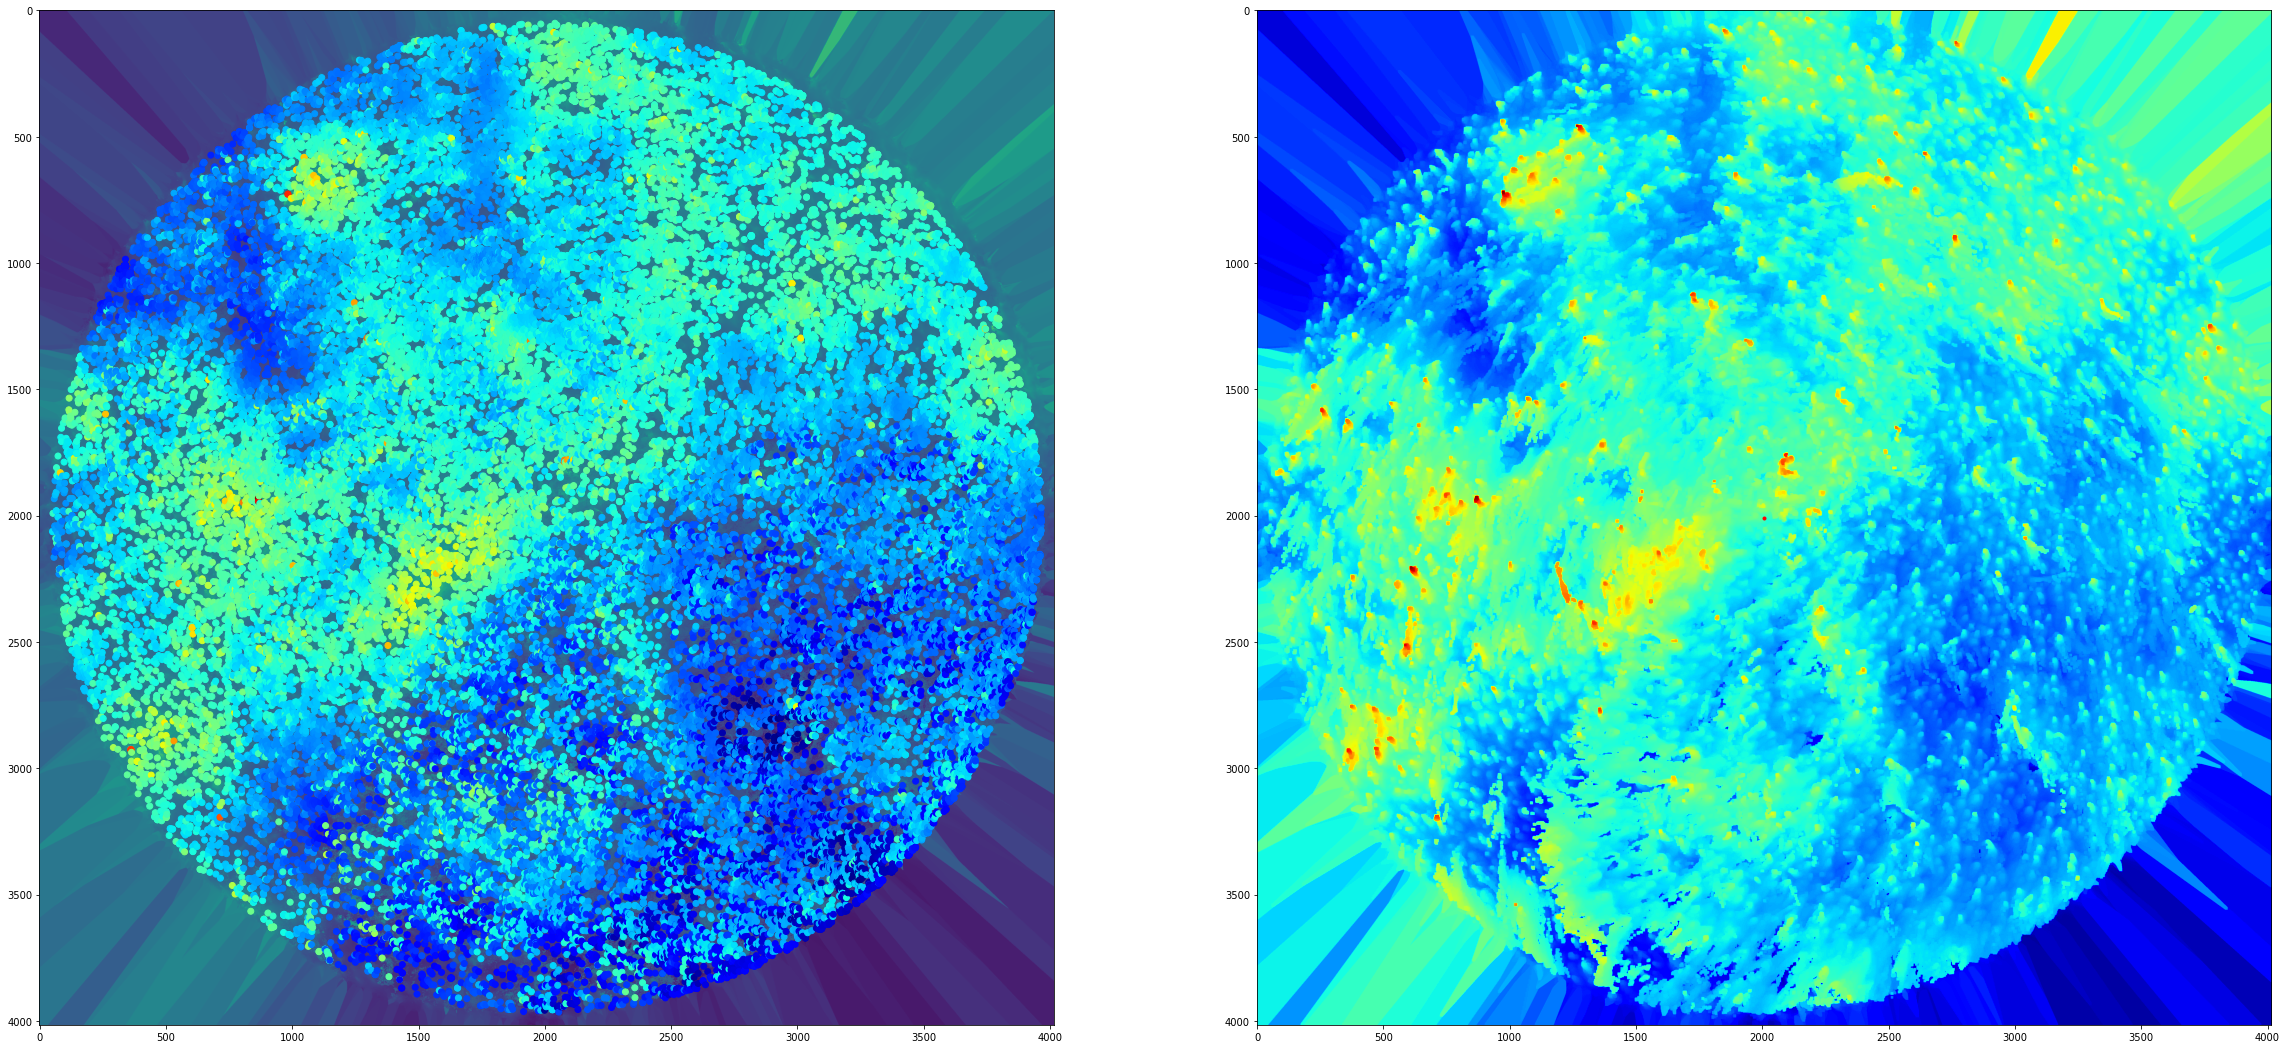

In [ ]:
#Getting data from .las file to numpy array
class PointCloud:
  def insertLAS(self, LAS):
    fileDataPath= LAS
    self.point_cloud=laspyPackage.read(fileDataPath)

  def printPointCloudDataCategories(self):
      for dimension in self.point_cloud.point_format.dimensions:
        print(dimension.name)

  def printZValues(self):
    zStack = numpyPackage.vstack(self.point_cloud.z).transpose()
    print(zStack)

  def extractxyzStack(self):
    self.xyzStack = numpyPackage.vstack((self.point_cloud.x, self.point_cloud.y, self.point_cloud.z)).transpose()

#KEYNOTE: metashape saves color as 16 bit so its 0-65536 instead of 0-255\
  def extractRGB(self):
    rgb = numpyPackage.vstack((self.point_cloud.red, self.point_cloud.green, self.point_cloud.blue)).transpose()

#interpolation > converting the data from a set of randomly spaced points into a continuous dataset 
  def interpolateData(self):
    self.xyzStack = numpyPackage.vstack((self.point_cloud.x, self.point_cloud.y, self.point_cloud.z)).transpose()
    a,b = self.xyzStack.shape
    self.size = int(numpyPackage.sqrt(a))

    x = numpyPackage.linspace(min(self.xyzStack[:,0]), max(self.xyzStack[:,0]), self.size)
    y = numpyPackage.linspace(min(self.xyzStack[:,1]), max(self.xyzStack[:,1]), self.size)
    self.X,self.Y = numpyPackage.meshgrid(x, y)

    self.Z = griddata((self.xyzStack[:,0], self.xyzStack[:,1]), self.xyzStack[:,2], (self.X,self.Y), method='nearest')

    self.xyzStack = numpyPackage.column_stack((self.X,self.Y,self.Z))

    Xsize = numpyPackage.shape(self.X)
    Ysize = numpyPackage.shape(self.Y)
    Zsize = numpyPackage.shape(self.Z)
    print("Xsize: ", Xsize)
    print("Ysize: ", Ysize)
    print("Zsize: ", Zsize)

    plotXYPackage.imshow(self.Z)
    plotXYPackage.show()

  def printSize(self):
    print(self.size)

####################finding the local maxima
#also why is the size 11?
  def findLocalMaxima(self):
    self.regmax = ndimage.maximum_filter(self.Z, size = 11)
    #finding which points in the original data are equal to our max-filtered data by finding where the Z values match 
    self.regmaxcoords = ndimage.maximum_filter(self.Z, size = 11) == self.Z

  def printListMaxZCoords(self):
    self.regmaxsize = numpyPackage.shape(self.regmax)
    print("regmax size: ", self.regmaxsize)

  def findXYvalofMaxZCoords(self):
    i, j = numpyPackage.where(self.regmaxcoords)
    self.coords = numpyPackage.column_stack((i,j))
    #Stack 1-D arrays as columns into a 2-D array
    self.coords2dArr = numpyPackage.column_stack((i,j))
    coordssize = numpyPackage.shape(self.coords)

  def cleanCoords(self):
    #masking the coordinates to only include whatever is inside the circle of valid points
    #the radius helps us find the center of the circle
    self.radius = self.size/2
    #to get the points within the circle, we use the equation (x-h)^2 + (y-k)^2 = r^2 (circle equation)
    #any set of x,y coordinates smaller than r^2 will be inside the circle we want to keep, and we will mask everything outside of that  
    mask = (self.coords[:,0]-(self.radius))**2 + (self.coords[:,1]-(self.radius))**2 < (self.radius-50)**2 #I use radius - 50 just to be safe and ensure we're excluding junk data
    self.cleanedCoords = self.coords[mask,:]
    self.cleanedcoordssize = numpyPackage.shape(self.cleanedCoords)

  def printRadius(self):
    print("rad: ", self.radius)


  def plotFilteredCoordsAsArr(self):  
    self.cleanedZ = numpyPackage.array([])
    for i,j in self.cleanedCoords:
      self.cleanedZ = numpyPackage.append(self.cleanedZ,self.Z[j,i])
    self.cleanedZ = numpyPackage.vstack(self.cleanedZ)



  def plotxyzStackCoordsAsArr(self):  
    self.cleanedxyzStack = numpyPackage.hstack((self.cleanedCoords, self.cleanedZ))
    cleanedxyzStacksize = numpyPackage.shape(self.cleanedxyzStack)

  def plotFigures(self):
    fig, (ax1, ax2) = plotXYPackage.subplots(1, 2, figsize = (40,40))
    #ax 1 (left) plots the original data and the pinnacle peaks onto it 
    ax1.imshow(self.Z)
    ax1.scatter(self.cleanedxyzStack[:,0], self.cleanedxyzStack[:,1], c = (self.cleanedxyzStack[:,2]*100000),cmap='jet')
    #ax 2 plots the max-filtered image 
    ax2.imshow(self.regmax, cmap = 'jet')
    ax2.plot(self.radius, self.radius, 'r.')
    plotXYPackage.show()
  
  def createNewSite(self, newSiteNameInput):
    #name should coordinate with original model name the data is derived from
    #include .csv so the file saves as the correct type
    newSiteName = newSiteNameInput

    #creates CSV containing your pinnacle peaks
    numpyPackage.savetxt(newSiteName, self.cleanedxyzStack, delimiter=",")



#pointCloudLocation depends on location of LAS stored in each individual computer
#CONSOLE = input LAS from your drive and rewrite output csv file 
pointCloudLocation = "gdrive/My Drive/Vanda Metashape/C5/8:00-9:41/C5 LAS/C5 8.00-9.42 sarahs edits.las"
newSiteNameInput = "gdrive/My Drive/Vanda Metashape/C5/8:00-9:41/C5 pinnacles finder/C5 pinnaclesfinder 8.00-9.42 sarahs edits.csv"

aPointCloud = PointCloud()
aPointCloud.insertLAS(pointCloudLocation)
aPointCloud.extractxyzStack()
aPointCloud.extractRGB()
aPointCloud.interpolateData()
aPointCloud.findLocalMaxima()
aPointCloud.findXYvalofMaxZCoords()
aPointCloud.cleanCoords()
aPointCloud.plotFilteredCoordsAsArr()
aPointCloud.plotxyzStackCoordsAsArr()
aPointCloud.plotFigures()
aPointCloud.createNewSite(newSiteNameInput)